In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

<AxesSubplot:>

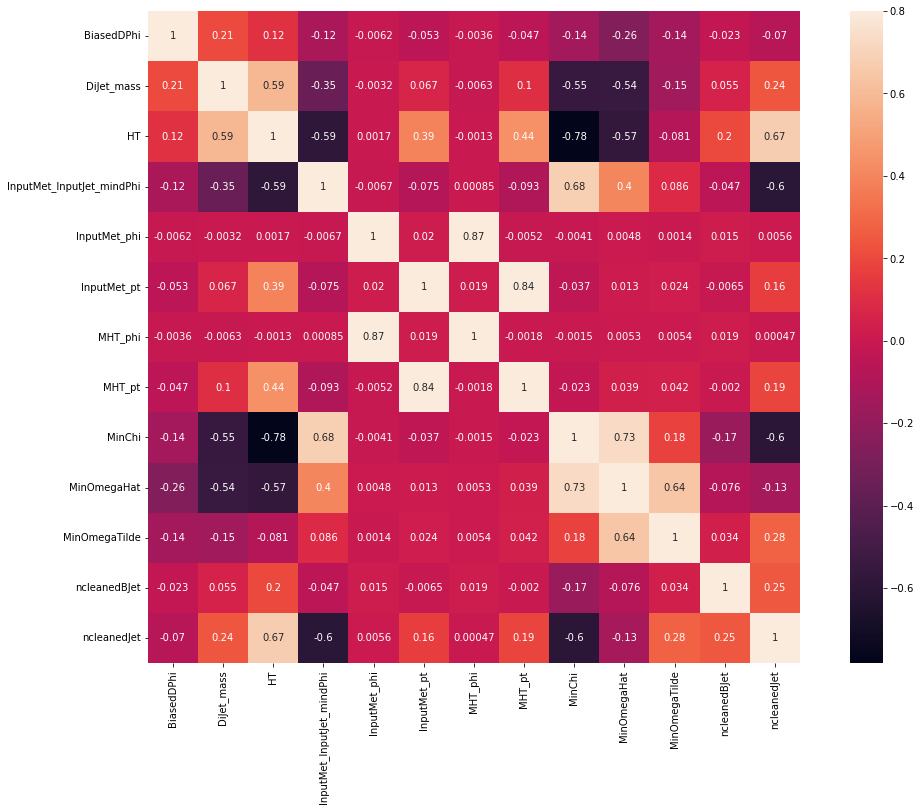

In [23]:
# correlation matrix

corrmat = data.corr()
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(corrmat, vmax=.8, annot=True, square=True)

Below is data analysis on the combined semi leptonic and ttH datasets

In [28]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# loads the dataframes
semi_leptonic_df = pd.read_hdf('/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/TTToSemiLeptonic/df_ml_inputs.hd5')
higgs_df = pd.read_hdf('/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/ttH125/df_ml_inputs.hd5')

# labels signal vs background
semi_leptonic_df['signal'] = 0
higgs_df['signal'] = 1

# combines the dataframes and randomly shuffles the rows
full_df = semi_leptonic_df.append(higgs_df, ignore_index=True)
full_df = shuffle(full_df)

In [45]:
# removes unnecessary columns
useful_cols = ['BiasedDPhi',
               'DiJet_mass',
               'HT', 
               'InputMet_InputJet_mindPhi',
               'InputMet_pt', 
               'MHT_pt',
               'MinChi',
               'MinOmegaHat',
               'MinOmegaTilde',
               'ncleanedBJet', 
               'ncleanedJet', 
               'signal',]

df = full_df[useful_cols]

# creates some new features for the NN
df['totalJets'] = df['ncleanedJet'] + df['ncleanedBJet']
df['totalJetMass'] = full_df['cleanedJet_mass'].apply(lambda x: sum(x))
df['totalJetArea'] = full_df['cleanedJet_area'].apply(lambda x: sum(x))
df['totalJet_pt'] = full_df['cleanedJet_pt'].apply(lambda x: sum(x))

# splits data into training and validation
X, y = df.drop('signal', axis=1), df['signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

X_train.head()

,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,totalJets,totalJetMass,totalJetArea,totalJet_pt
331286,1.955762,162.943114,480.548462,2.335938,467.000,395.740784,1.570796,1.194275,1.051368,0,5,5,73.265625,2.424072,480.548454
230979,-2.659946,102.935817,297.406067,0.506348,239.625,253.574677,1.570796,1.074885,0.838709,0,3,3,39.875000,1.535889,297.406052
189929,0.263459,108.837982,537.246887,2.648438,365.250,401.553162,1.245252,1.175157,0.989974,3,6,9,72.671875,3.042480,537.246918
103782,-3.119535,94.761730,325.900818,1.571289,200.125,209.058029,1.392467,1.094529,0.755287,1,5,6,60.589844,2.353516,325.900824
118535,-2.453047,480.431867,623.816833,1.522461,277.250,280.497437,0.925028,0.873557,0.804015,0,4,4,75.796875,1.984619,623.816788


In [ ]:
# number of signal events and background events
y.value_counts()

0    296226
1     99305
Name: signal, dtype: int64

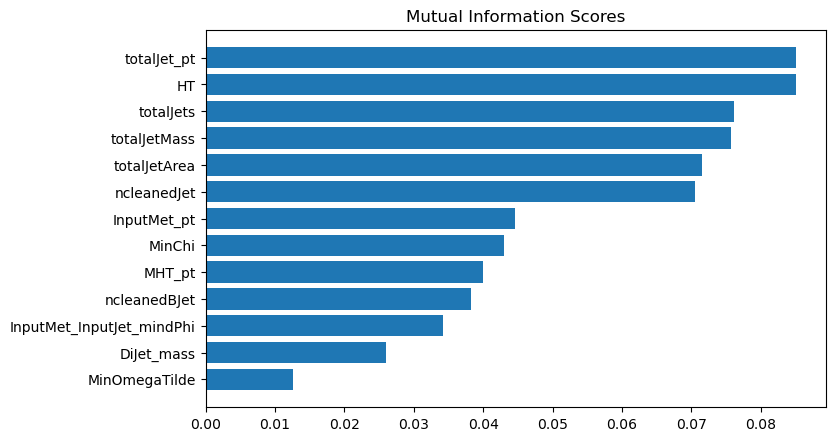

In [ ]:
# shows mutual information score for each feature
from sklearn.feature_selection import mutual_info_classif

discrete_features = (X.dtypes == int)

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Score", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

# plots the mutual information scores
def plot_scores(scores, title):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title(title)


plt.figure(dpi=100, figsize=(8, 5))
plot_scores(mi_scores, "Mutual Information Scores")

<AxesSubplot:>

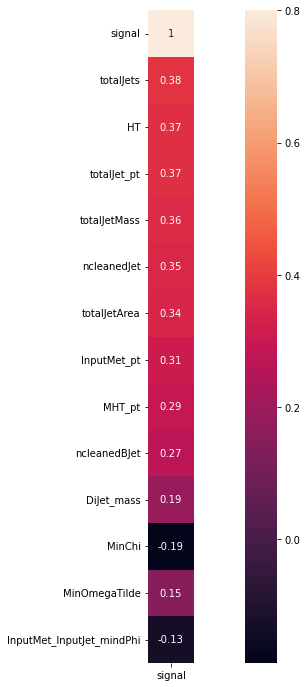

In [ ]:
# shows how the signal correlates with other variables

corrmat = df.corr()
corr = corrmat[['signal']].sort_values(by=['signal'], ascending=False, key=abs)
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(corr, vmax=.8, annot=True, square=True)

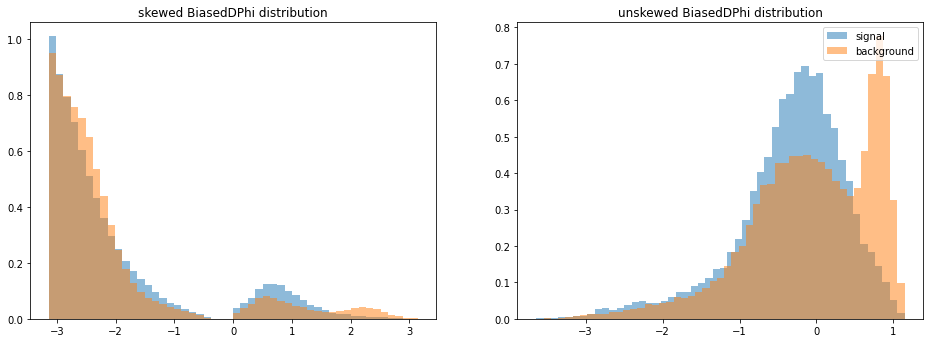

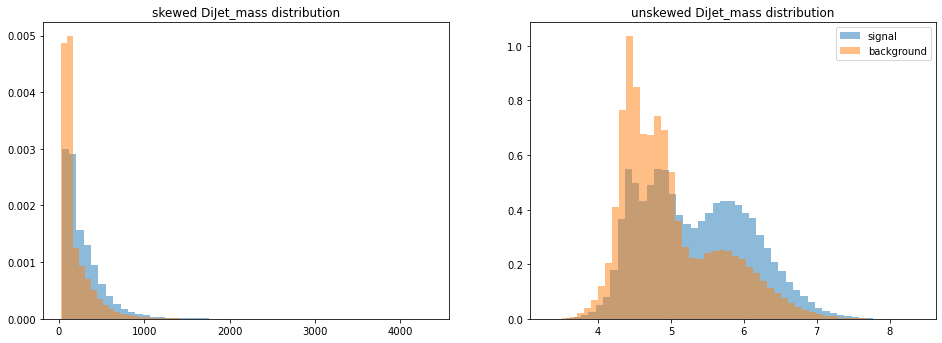

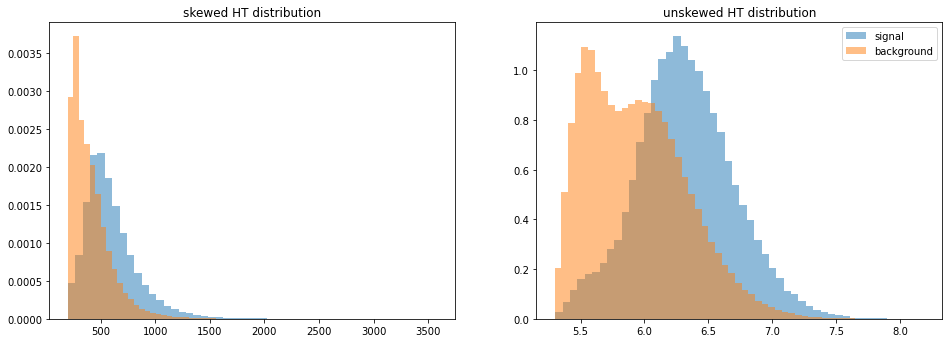

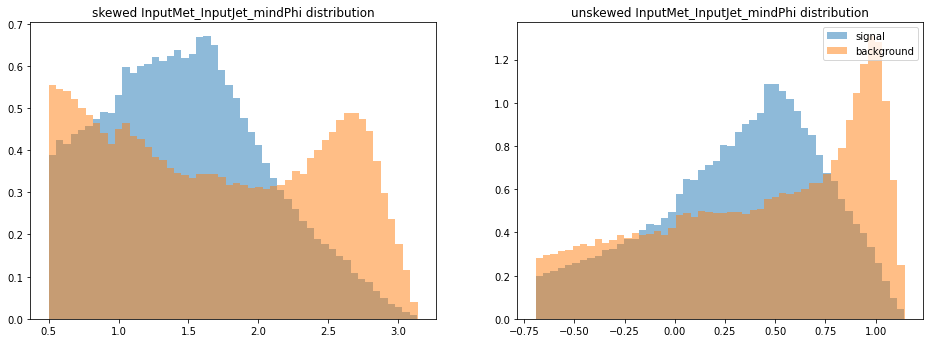

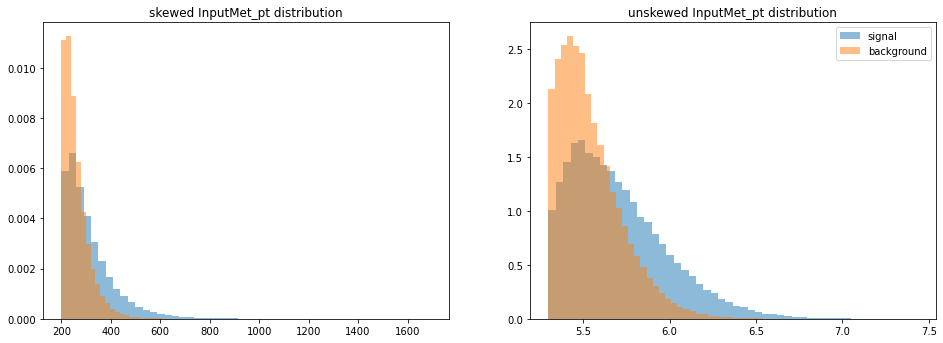

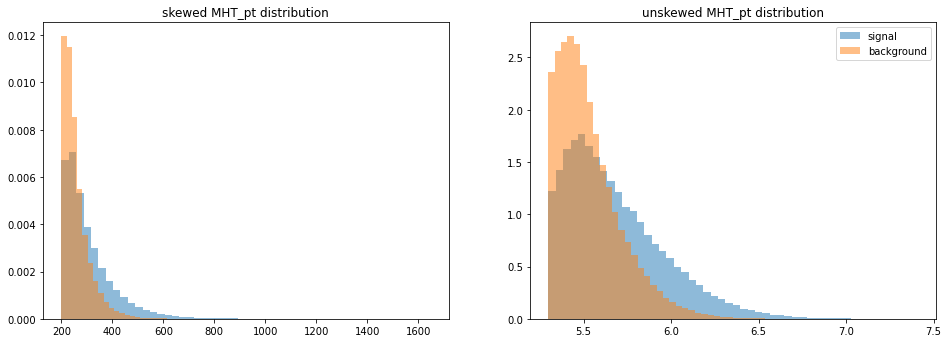

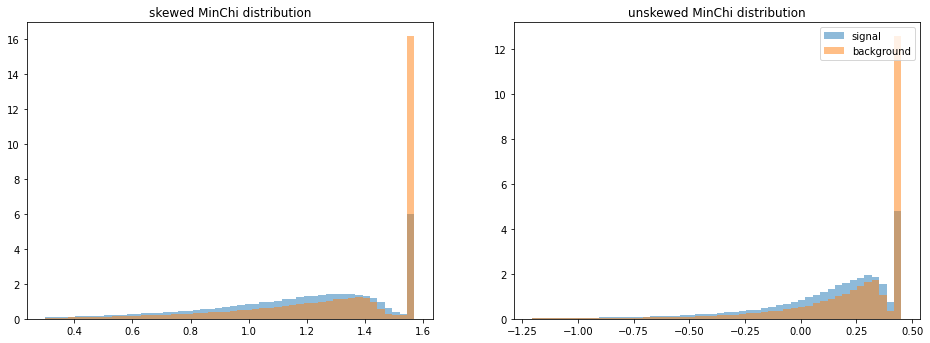

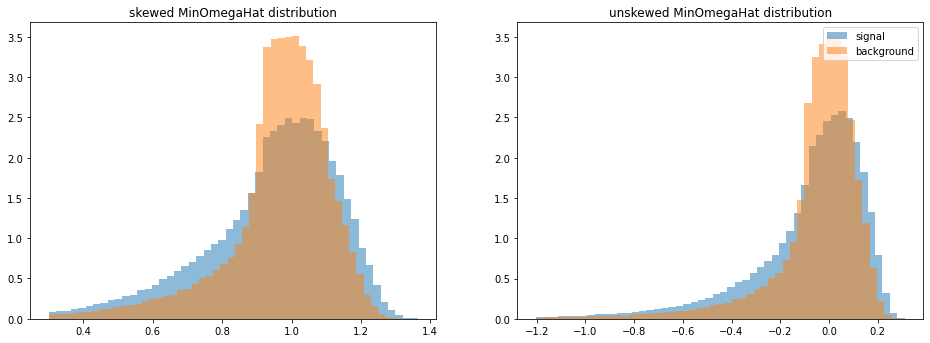

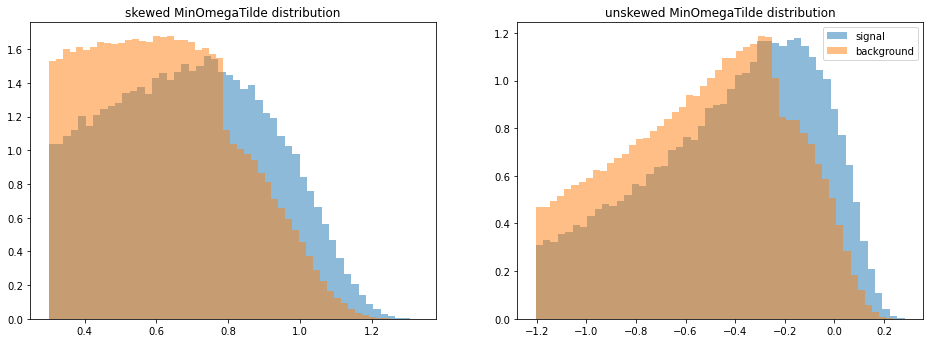

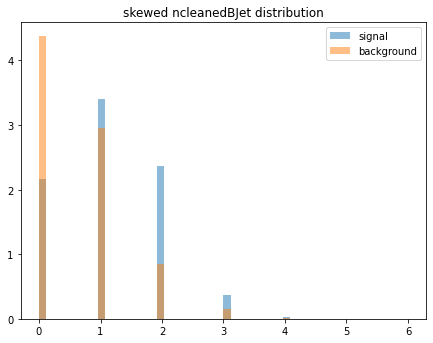

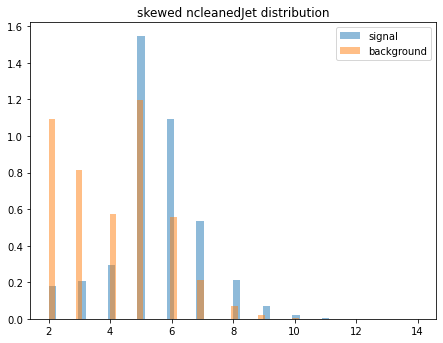

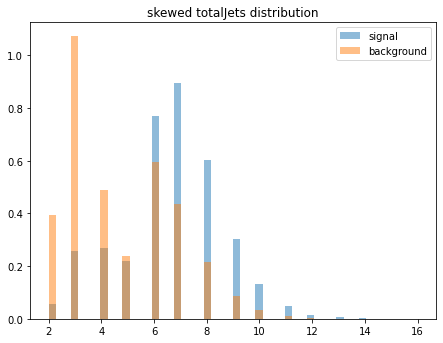

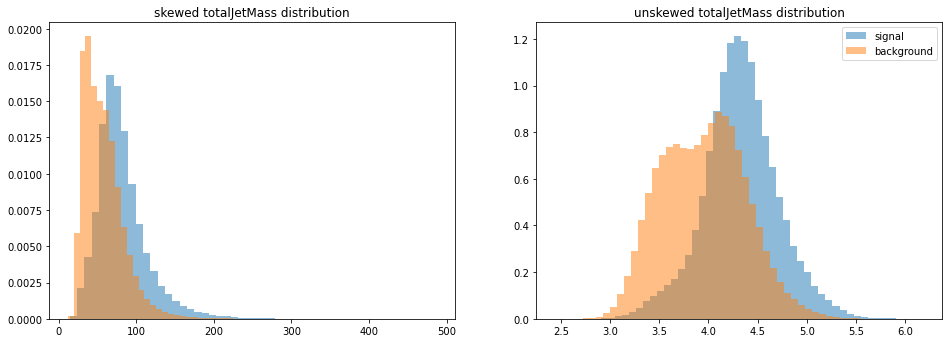

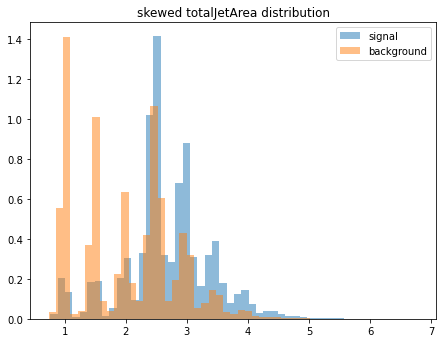

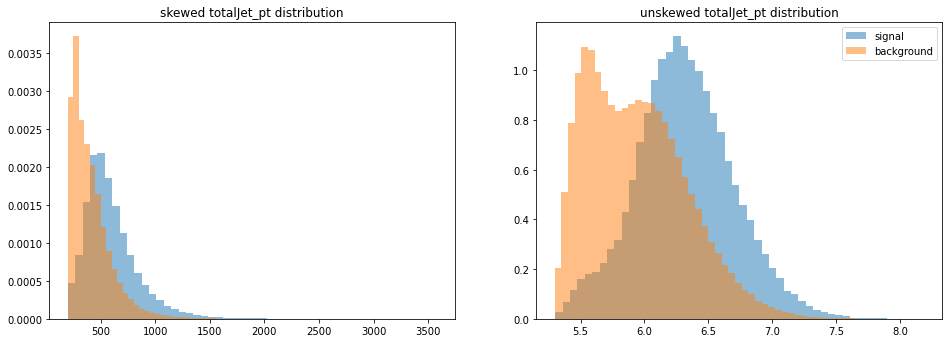

Index(['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'ncleanedBJet', 'ncleanedJet', 'totalJets', 'totalJetMass',
       'totalJetArea', 'totalJet_pt'],
      dtype='object')


In [61]:
def hist_comparison(col_name, df=df):

    bins = 50

    signal = df[col_name].loc[df['signal'] == 1]
    bg = df[col_name].loc[df['signal'] == 0] 

    plt.figure(figsize=(16,12))
    
    # skewed plot
    plt.subplot(2,2,1)
    plt.title(f'skewed {col_name} distribution')
    plt.hist(signal, bins, alpha=0.5, label='signal', density=True)
    plt.hist(bg, bins, alpha=0.5, label='background', density=True)

    if col_name not in ['ncleanedBJet', 'ncleanedJet', 'totalJets', 'totalJetArea']:
        unskewed_signal = np.log(signal)
        unskewed_bg = np.log(bg)
        
        # unskewed plot
        plt.subplot(2,2,2)
        plt.title(f'unskewed {col_name} distribution')
        plt.hist(unskewed_signal, bins, alpha=0.5, label='signal', density=True)
        plt.hist(unskewed_bg, bins, alpha=0.5, label='background', density=True)

    plt.legend(loc='upper right')
    plt.show()

for col in X.columns:
    hist_comparison(col)
print(X.columns)